In [1]:
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import struct
import pandas as pd

In [2]:
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP, UDP

In [3]:
print("Comments on 24 first elements of the pcap.\n \
The total size of the PCAP Global Header is 24 bytes.\n \
1. Magic Number: 4 bytes\nThis is a constant value (0xA1B2C3D4 for standard PCAP files or 0x0A0D0D0A for PCAP-NG).\n \
2. Version Major: 2 bytes\nThe major version number of the PCAP file format (typically 2).\n \
3. Version Minor: 2 bytes\nThe minor version number of the PCAP file format (typically 4).\n \
4. ThisZone: 4 bytes\nTime zone offset in seconds from UTC (usually 0 for UTC).\n \
5. Sigfigs: 4 bytes\nThe number of significant figures in the timestamp (typically 0).\n \
6. SnapLen: 4 bytes\nThe maximum number of bytes to capture for each packet (i.e., snapshot length).\n \
7. LinkType: 4 bytes\nThe type of link-layer protocol used in the capture (e.g., Ethernet, Wi-Fi).")

Comments on 24 first elements of the pcap.
 The total size of the PCAP Global Header is 24 bytes.
 1. Magic Number: 4 bytes
This is a constant value (0xA1B2C3D4 for standard PCAP files or 0x0A0D0D0A for PCAP-NG).
 2. Version Major: 2 bytes
The major version number of the PCAP file format (typically 2).
 3. Version Minor: 2 bytes
The minor version number of the PCAP file format (typically 4).
 4. ThisZone: 4 bytes
Time zone offset in seconds from UTC (usually 0 for UTC).
 5. Sigfigs: 4 bytes
The number of significant figures in the timestamp (typically 0).
 6. SnapLen: 4 bytes
The maximum number of bytes to capture for each packet (i.e., snapshot length).
 7. LinkType: 4 bytes
The type of link-layer protocol used in the capture (e.g., Ethernet, Wi-Fi).


# FUNCTIONS #

In [4]:
def convert_timestamp_to_utc(seconds, microseconds):
    # Create a datetime object from the seconds since epoch in UTC
    timestamp = datetime.datetime.utcfromtimestamp(seconds)
    
    # Add the microseconds part to the timestamp
    timestamp_with_microseconds = timestamp + datetime.timedelta(microseconds=microseconds)
    
    # Return the formatted datetime in UTC with microseconds
    return timestamp_with_microseconds.strftime('%Y-%m-%d %H:%M:%S.%f')

In [219]:
# Function to unpack and convert each row in the matrix to a timestamp
def convert_matrix_to_timestamps(frame_timestamp):
    # Initialize an empty list to hold the formatted timestamps
    timestamps = []
    
    # Iterate over each row in the matrix
    for row in frame_timestamp:
        # Convert the row (16 bytes) to binary (packed format)
        packet_header = bytes(row)
        
        # Unpack the packet header (16 bytes)
        ts_sec, ts_usec, captured_len, packet_len = struct.unpack('<IIII', packet_header)
        
        # Use the provided function to convert to a formatted timestamp
        formatted_timestamp = convert_timestamp_to_utc(ts_sec, ts_usec)
        
        # Append the formatted timestamp to the list
        timestamps.append(formatted_timestamp)
    
    return timestamps

In [6]:
def read_pcap(file_path):
    with open(file_path, 'rb') as f:
        # Read the global header (24 bytes)
        global_header = f.read(24)
        magic_number, version_major, version_minor, this_zone, sigfigs, snap_len, link_type = struct.unpack('<IHHIIII', global_header)

        print("PCAP Global Header Information:")
        print(f"Magic Number: {hex(magic_number)}")
        print(f"Version: {version_major}.{version_minor}")
        print(f"Timezone: {this_zone}")
        print(f"Snapshot Length: {snap_len}")
        print(f"Link Type: {link_type}")

        # Now, read each packet's header and payload
        packet_count = 0
        while True:
            packet_header = f.read(16)
            if len(packet_header) < 16:
                break  # End of file or incomplete packet
            
            # Unpack the packet header (16 bytes)
            ts_sec, ts_usec, captured_len, packet_len = struct.unpack('<IIII', packet_header)
            
            # Convert timestamp to UTC
            timestamp_utc = convert_timestamp_to_utc(ts_sec, ts_usec)
            
            # Print packet header details
            print(f"\nPacket {packet_count + 1}:")
            print(f"Timestamp (UTC): {timestamp_utc}")
            print(f"Captured Length: {captured_len} bytes")
            print(f"Original Packet Length: {packet_len} bytes")

            # Read the payload (captured data)
            payload = f.read(captured_len)
            print(f"Payload (first 16 bytes): {payload[:16]}")

            packet_count += 1

In [224]:
def read_138_bytes(header):
    print("Shape frame headers:", frame_headers.shape)
    first_header = header
    print("Shape single header: ", first_header.shape)
    first_header_byte = bytes(first_header)
    spead0, spead1, spead_a, spead_b, spead2, spead3, \
    spead4, spead_c, spead_d, spead5, spead6, spead7, \
    = struct.unpack(">QQQQQQQQQQQQ", first_header_byte[42:138])

    # Separate the magic and header_length
    magic = (spead0 >> 32) & 0xFFFFFFFF  # Extract the upper 32 bits
    header_length = spead0 & 0xFFFFFFFF   # Extract the lower 32 bits

    # Separate the Packet_counter (upper 2 bytes) and header_counter (lower 6 bytes)
    Packet_counter = (spead1 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    heap_counter = spead1 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Separate the heap_size (upper 2 bytes) and below_heap_size (lower 6 bytes)
    heap_size = (spead_a >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    below_heap_size = spead_a & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    heap_offset = (spead_b >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    packet_couner = spead_b & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Packet_length = (spead2 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    below_Packet_length = spead2 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Centre_frequency = (spead3 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_Centre_frequency = spead3 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Integration_length_spectra = (spead4 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_Integration_length_spectra = spead4 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Nof_chanels = (spead_c >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_Nof_chanels = spead_c & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Timestamp_frequency = (spead_d >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_Timestamp_frequency = spead_d & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    sync_time = (spead5 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_sync_time = spead5 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    Timestamp_spead = (spead6 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_timestamp = spead6 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    # Same ideia
    SPEAD_start_data = (spead7 >> 48) & 0xFFFF  # Extract the upper 16 bits (2 bytes)
    value_SPEAD_start_data = spead7 & 0xFFFFFFFFFFFF  # Extract the lower 48 bits (6 bytes)

    print(f"\nSPEAD magic: {hex(magic)}")
    print(f"Header length: {header_length}")

    print(f"\nPacket_Counter: {Packet_counter}")
    print(f"heap_Counter: {heap_counter}")

    print(f"\nheap size: {heap_size}")
    print(f"below heap size: {below_heap_size}")

    print(f"\nHeap_offset: {heap_offset}")
    print(f"packet_couner: {packet_couner}")

    print(f"\nPacket length: {Packet_length}")
    print(f"below Packet length: {below_Packet_length}")

    print(f"\nCentre frequency: {Centre_frequency}")
    print(f"value Centre frequency: {value_Centre_frequency}")

    print(f"\nIntegration_length_spectra: {Integration_length_spectra}")
    print(f"value_Integration_length_spectra: {value_Integration_length_spectra}")

    print(f"\nNof_chanels: {Nof_chanels}")
    print(f"value_Nof_chanels: {value_Nof_chanels}")

    print(f"\nTimestamp_frequency: {Timestamp_frequency}")
    print(f"value_Timestamp_frequency: {value_Timestamp_frequency}")

    print(f"\nsync_time: {sync_time}")
    print(f"value_sync_time: {value_sync_time}")

    print(f"\nTimestamp_spead: {Timestamp_spead}")
    print(f"value_timestamp: {value_timestamp}")

    print(f"\nSPEAD_start_data: {SPEAD_start_data}")
    print(f"value_SPEAD_start_data: {value_SPEAD_start_data}")

# READING PCAP FILES #

In [8]:
# Example usage
file_path = '/home/bingo/capture_bingo_dec16.pcap'  # Replace with your PCAP file path
read_pcap(file_path)

PCAP Global Header Information:
Magic Number: 0xa1b2c3d4
Version: 2.4
Timezone: 0
Snapshot Length: 262144
Link Type: 1

Packet 1:
Timestamp (UTC): 2025-04-16 15:37:03.954610
Captured Length: 8330 bytes
Original Packet Length: 8330 bytes
Payload (first 16 bytes): b'\x1c\xfd\x08}X\x99\x06P\x02\x0f\x04\x01\x08\x00E\x00'

Packet 2:
Timestamp (UTC): 2025-04-16 15:37:03.954653
Captured Length: 8330 bytes
Original Packet Length: 8330 bytes
Payload (first 16 bytes): b'\x1c\xfd\x08}X\x99\x06P\x02\x0f\x04\x01\x08\x00E\x00'

Packet 3:
Timestamp (UTC): 2025-04-16 15:37:03.954655
Captured Length: 8330 bytes
Original Packet Length: 8330 bytes
Payload (first 16 bytes): b'\x1c\xfd\x08}X\x99\x06P\x02\x0f\x04\x01\x08\x00E\x00'

Packet 4:
Timestamp (UTC): 2025-04-16 15:37:03.954657
Captured Length: 8330 bytes
Original Packet Length: 8330 bytes
Payload (first 16 bytes): b'\x1c\xfd\x08}X\x99\x06P\x02\x0f\x04\x01\x08\x00E\x00'

Packet 5:
Timestamp (UTC): 2025-04-16 15:37:03.954659
Captured Length: 8330 byte

In [9]:
header_number_bytes = 24 #bytes
payload_number_bytes = 8330 #bytes
timestamp_number_bytes = 16 #bytes
number_of_packets = 10000

total_bytes = header_number_bytes + (payload_number_bytes + timestamp_number_bytes) * number_of_packets
print("total bytes in the pcap: ", total_bytes)

total bytes in the pcap:  83460024


In [10]:
pcapfiles=sorted(glob.glob('*.pcap'))
print("Pcap Files available in the folder: \n")
print(pcapfiles)

print("\n")

print("Number of pcap files available: \n")
print(len(pcapfiles))

Pcap Files available in the folder: 

['capture_bingo_dec16.pcap']


Number of pcap files available: 

1


In [11]:
with open(file_path,'rb') as f:
    mybuff=f.read()

#o zspectro está com banda de 93.75 MHz e 32768 canais

# PCAP STRUCTURE #

In [12]:
dt = np.dtype('int8')

# Read the PCAP buffer starting from the 24th byte onward
coisa_int8 = np.frombuffer(mybuff, dt)
newcoisa_int8 = coisa_int8[:24]  # Extract the relevant part of the buffer

# Define the PCAP global header structure in terms of the number of bytes for each field
# Magic number (4 bytes), Version (2 bytes), Timezone offset (4 bytes), etc.
magic_number = int.from_bytes(newcoisa_int8[0:4], byteorder='little')  # 4 bytes
version_major = int.from_bytes(newcoisa_int8[4:6], byteorder='little')  # 2 bytes
version_minor = int.from_bytes(newcoisa_int8[6:8], byteorder='little')  # 2 bytes
this_zone = int.from_bytes(newcoisa_int8[8:12], byteorder='little')  # 4 bytes
sigfigs = int.from_bytes(newcoisa_int8[12:16], byteorder='little')  # 4 bytes
snap_len = int.from_bytes(newcoisa_int8[16:20], byteorder='little')  # 4 bytes
link_type = int.from_bytes(newcoisa_int8[20:24], byteorder='little')  # 4 bytes

# Print the parsed fields in a human-readable format
print("PCAP Global Header:")
print(f"Magic Number: {hex(magic_number)}")
print(f"Version Major: {version_major}")
print(f"Version Minor: {version_minor}")
print(f"Time Zone Offset (ThisZone): {this_zone}")
print(f"Significant Figures (Sigfigs): {sigfigs}")
print(f"Snapshot Length (SnapLen): {snap_len}")
print(f"Link Type: {link_type}")

PCAP Global Header:
Magic Number: 0xa1b2c3d4
Version Major: 2
Version Minor: 4
Time Zone Offset (ThisZone): 0
Significant Figures (Sigfigs): 0
Snapshot Length (SnapLen): 262144
Link Type: 1


In [13]:
#mostrar tamanho em bytes (8 bits)
print("size of pcap file (in bytes): \n")
print(len(mybuff))
#mostrar em formato binário (scary!) 
print("\n")
print("Array in binary: \n")
print(mybuff[:60])

print("\n")
#mostrar em formato hexdecimal (less scary!)
print("Array in hex: \n", )
print(mybuff[:60].hex())

size of pcap file (in bytes): 

1468920


Array in binary: 

b'\xd4\xc3\xb2\xa1\x02\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x00\x00\x00\x9f\xce\xffg\xf2\x90\x0e\x00\x8a \x00\x00\x8a \x00\x00\x1c\xfd\x08}X\x99\x06P\x02\x0f\x04\x01\x08\x00E\x00 |\x00\x00'


Array in hex: 

d4c3b2a102000400000000000000000000000400010000009fceff67f2900e008a2000008a2000001cfd087d58990650020f040108004500207c0000


In [14]:
"""
Transformar em um np.array formado de int8 o array acima para manter a quantidade de números.
Isso vai ajudar a manipular o array com os métodos do numpy
Removemos os 24 primeiros elementos, pois é uma espécie de header geral. 
O procedimento será ir descobrindo o que é header geral (comparando com o output do wireshark),
e depois ver o que é header e dados em cada header
"""

dt = np.dtype('int8')
mybuff_bytes = np.frombuffer(mybuff,dt)
udp_packets_1d= mybuff_bytes[24:]
print(udp_packets_1d.shape)
print("\n")
print(udp_packets_1d[:100].data.hex())

(1468896,)


9fceff67f2900e008a2000008a2000001cfd087d58990650020f040108004500207c00004000ff1150820a2a00c5000000002710000020680000530402060000000b800100000000000b8002000000080000800300000000000080040000000020009011


In [15]:
# fazer um reshape com 8346 e o que sobra é o número de frames.
# Controlamos o número de frames com o flag -c no tcpdump
trimmed_length = (len(udp_packets_1d) // 8346) * 8346

udp_packets_trimmed = udp_packets_1d[:trimmed_length]

udp_packets = udp_packets_trimmed.reshape(-1, 8346)
print(udp_packets.shape)
print(udp_packets)
# notar que as colunas iniciais são iguais, implicando algum tipo de header (iguais) de cada frame

(176, 8346)
[[-97 -50  -1 ...   0   0  21]
 [-97 -50  -1 ...   0   0  29]
 [-97 -50  -1 ...   0   0  29]
 ...
 [-87 -50  -1 ...   0   0  25]
 [-87 -50  -1 ...   0   0  18]
 [-87 -50  -1 ...   0   0   3]]


## FRAME TIMESTAMP ##

In [16]:
frame_timestamp = udp_packets[:,:16]

In [17]:
print(frame_timestamp.shape)
print(frame_timestamp[:5, :])

(176, 16)
[[ -97  -50   -1  103  -14 -112   14    0 -118   32    0    0 -118   32
     0    0]
 [ -97  -50   -1  103   29 -111   14    0 -118   32    0    0 -118   32
     0    0]
 [ -97  -50   -1  103   31 -111   14    0 -118   32    0    0 -118   32
     0    0]
 [ -97  -50   -1  103   33 -111   14    0 -118   32    0    0 -118   32
     0    0]
 [ -97  -50   -1  103   35 -111   14    0 -118   32    0    0 -118   32
     0    0]]


In [89]:
# Convert the matrix into timestamps
timestamps = convert_matrix_to_timestamps(frame_timestamp)

In [90]:
timestamps[:10]

(['2025-04-16 15:37:03.954610',
  '2025-04-16 15:37:03.954653',
  '2025-04-16 15:37:03.954655',
  '2025-04-16 15:37:03.954657',
  '2025-04-16 15:37:03.954659',
  '2025-04-16 15:37:03.954661',
  '2025-04-16 15:37:03.954663',
  '2025-04-16 15:37:03.954705',
  '2025-04-16 15:37:03.954707',
  '2025-04-16 15:37:03.954709',
  '2025-04-16 15:37:03.954711',
  '2025-04-16 15:37:03.954713',
  '2025-04-16 15:37:03.954752',
  '2025-04-16 15:37:03.954754',
  '2025-04-16 15:37:03.954756',
  '2025-04-16 15:37:03.954758',
  '2025-04-16 15:37:04.954597',
  '2025-04-16 15:37:04.954608',
  '2025-04-16 15:37:04.954610',
  '2025-04-16 15:37:04.954641',
  '2025-04-16 15:37:04.954643',
  '2025-04-16 15:37:04.954645',
  '2025-04-16 15:37:04.954647',
  '2025-04-16 15:37:04.954690',
  '2025-04-16 15:37:04.954692',
  '2025-04-16 15:37:04.954693',
  '2025-04-16 15:37:04.954695',
  '2025-04-16 15:37:04.954697',
  '2025-04-16 15:37:04.954737',
  '2025-04-16 15:37:04.954739',
  '2025-04-16 15:37:04.954740',
  '2025-

## FRAME HEADERS ##

In [20]:
# retira um header antes dos dados do UDP...o pacote UDP tem 8330 bytes (ou int8) de acordo com o wireshark 
# Daí tem uma parte para ser removida até 8288 e por fim dados mesmo são 8192. 
# Portanto será preciso remover ainda 8330-8192=138 elementos no início de cada frame
udp_intermediary=udp_packets[:,16:]

print("UDP_intermediary shape:", udp_intermediary.shape)
print("\n")
print(udp_intermediary[:10,:10])
print("\n")
print(udp_intermediary.flatten()[:148].data.hex())

UDP_intermediary shape: (176, 8330)


[[  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]]


1cfd087d58990650020f040108004500207c00004000ff1150820a2a00c5000000002710000020680000530402060000000b800100000000000b8002000000080000800300000000000080040000000020009011000000000000901500000000165a9009000000008000904600000a6e49c09027000000000013960000000352a10d180000000000000000000003000000030000


### SPEAD magic: 0x53040206 ###

In [217]:
frame_headers=udp_intermediary[:,:138]

print("Frame headers (int8): \n")
print(frame_headers[:10, :])
print("\n")
print(frame_headers.shape)
print("\n")
print("SPEAD magic number: 0x", frame_headers.flatten()[42:46].data.hex())

Frame headers (int8): 

[[28 -3  8 ...  0  0  0]
 [28 -3  8 ...  0  0  0]
 [28 -3  8 ...  0  0  0]
 ...
 [28 -3  8 ...  0  0  0]
 [28 -3  8 ...  0  0  0]
 [28 -3  8 ...  0  0  0]]


(176, 138)


SPEAD magic number: 0x 53040206


### SPEAD METADATA!!! ###

In [261]:
read_138_bytes(frame_headers[96])

Shape frame headers: (176, 138)
Shape single header:  (138,)

SPEAD magic: 0x53040206
Header length: 11

Packet_Counter: 32769
heap_Counter: 17

heap size: 32770
below heap size: 524288

Heap_offset: 32771
packet_couner: 0

Packet length: 32772
below Packet length: 8192

Centre frequency: 36881
value Centre frequency: 0

Integration_length_spectra: 36885
value_Integration_length_spectra: 5722

Nof_chanels: 36873
value_Nof_chanels: 32768

Timestamp_frequency: 36934
value_Timestamp_frequency: 175000000

sync_time: 36903
value_sync_time: 25

Timestamp_spead: 38400
value_timestamp: 130737805

SPEAD_start_data: 6144
value_SPEAD_start_data: 0


## PAYLOAD ##

In [23]:
#138  -> 10

udp_payload = udp_intermediary[:,138:]
print(udp_payload.shape)
print("\n")
print(udp_payload[0:25,0:100])
print("\n")
print(udp_payload.flatten()[:10].data.hex())

(176, 8192)


[[ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0 21]
 [ 0  0  0 ...  0  0 30]
 ...
 [ 0  0  0 ...  0  0 27]
 [ 0  0  0 ...  0  0 25]
 [ 0  0  0 ...  0  0 26]]


00000003000000030000


In [24]:
udp_payload_array=udp_payload.reshape(-1)  # pode ser usado o método .flatten().
print(udp_payload_array.shape)
print(udp_payload_array[:10])

(1441792,)
[0 0 0 3 0 0 0 3 0 0]


In [25]:
# Voltar para bytes
udp_payload_array_bytes = udp_payload_array.tobytes()

# caso queira ver em hex.
#te1_hex=te1.data.hex()
#print(te1_hex[:50])

In [26]:
# os dados estão codificados em int16. Agora é para valer:

dt = np.dtype('uint32')
udp_payload_uint32_array = np.frombuffer(udp_payload_array_bytes,dt)
print(udp_payload_uint32_array.shape)

(360448,)


In [27]:
udp_payload_uint32_array[0:100]

array([50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331648,
       50331648, 50331648, 50331648, 50331648, 50331648, 50331

In [28]:
ADC_Channel = 0

data_spectrometer_array = udp_payload_uint32_array[ADC_Channel::4]

data_spectrometer_array.shape

(90112,)

In [29]:
# TWO ADC INPUTS

#number_of_spectra = len(data_spectrometer_array) // 32768
#print(number_of_spectra)

# ONE SINGLE ADC INPUT

number_of_spectra = len(udp_payload_uint32_array) // 32768
print(number_of_spectra)

11


In [30]:
# TWO ADC INPUTS

#spectrometer_array = data_spectrometer_array[0:number_of_spectra * 32768]

# ONE SINGLE ADC CHANNEL

spectrometer_array = udp_payload_uint32_array[0:number_of_spectra * 32768]

In [31]:
len(spectrometer_array)

360448

# SPECTROMETER AND WATERFALL #

In [32]:
spectrometer_matrix = spectrometer_array.reshape(-1,32768)
spectrometer_matrix.shape

(11, 32768)

In [33]:
#o zspectro está com banda de 93.75 MHz e 32768 canais
bw=93.75
fc=900
fi,ff=fc-bw/2, fc+bw/2
freqs=np.linspace(fi, ff, spectrometer_matrix.shape[1])

ti, tf=0, spectrometer_matrix.shape[0]
tt=np.linspace(ti,tf,tf)

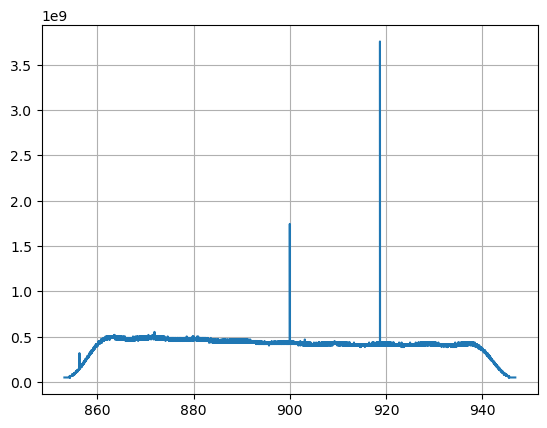

In [35]:
plt.plot(freqs, spectrometer_matrix[10,:])
plt.grid()

<Figure size 1200x1200 with 0 Axes>

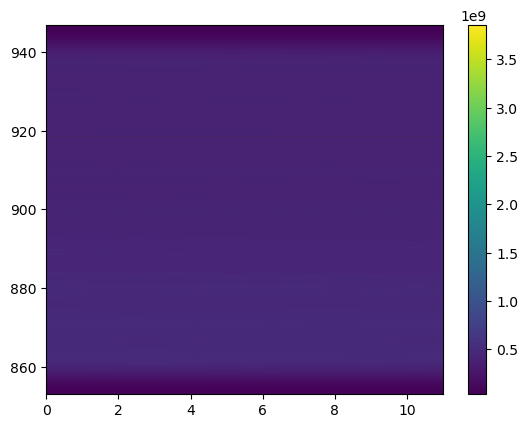

<Figure size 1200x1200 with 0 Axes>

In [36]:
plt.pcolormesh(tt,freqs,spectrometer_matrix.T,shading='gouraud')
plt.colorbar()
plt.figure(figsize=(12,12))

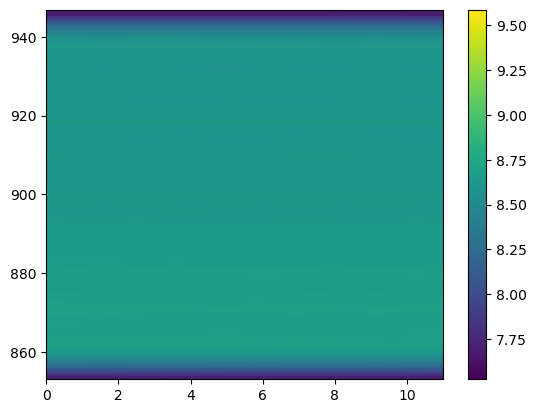

In [37]:
plt.pcolormesh(tt,freqs,np.log10(spectrometer_matrix.T),shading='gouraud')
plt.colorbar()

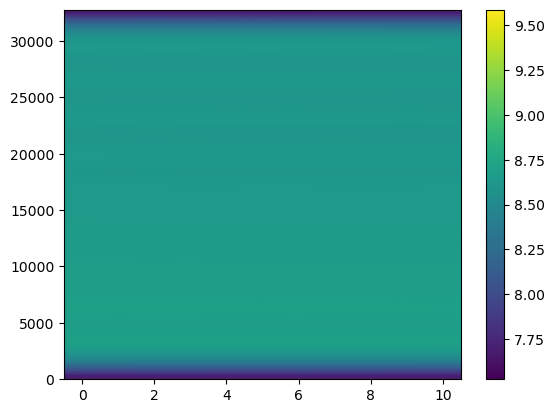

In [38]:
plt.imshow(np.log10(spectrometer_matrix.T),aspect='auto',origin='lower')
plt.colorbar()

In [39]:
print(spectrometer_matrix.shape)

(11, 32768)


In [40]:
# média ao longo de alguns canais para combinar em canais maiores

newmat=spectrometer_matrix.T.reshape(-1,16,32)
print(newmat.shape)
finalmat=np.mean(newmat,axis=1)
print(finalmat.shape)

(704, 16, 32)
(704, 32)


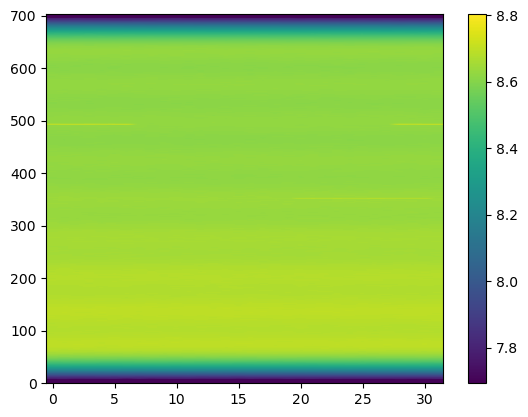

In [41]:
plt.imshow(np.log10(finalmat),aspect='auto',origin='lower')
plt.colorbar()

In [42]:
finalmat.shape

(704, 32)

In [43]:
# Fazendo uma figura mais bacana

# o que plotar

frqs=np.linspace(fi,ff,finalmat.shape[0])
tts=np.linspace(ti,tf,finalmat.shape[1])

t_series=np.mean(finalmat,axis=0)
specs_mean=np.mean(finalmat,axis=1)

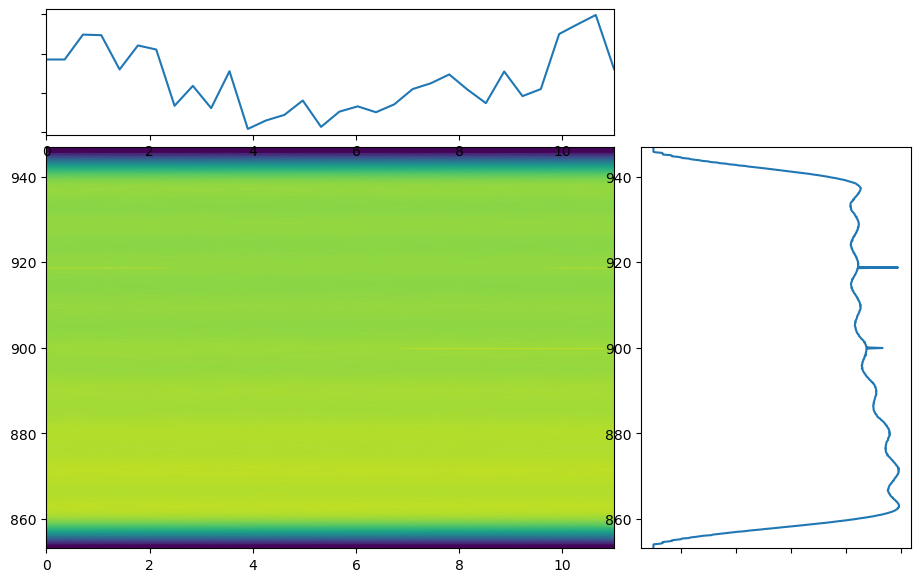

In [44]:

#Montando a grade
fig=plt.figure(figsize=(15,7))
mygrid=plt.GridSpec(4,4,hspace=0.1,wspace=0.1)

main_ax=fig.add_subplot(mygrid[1:,:2])
time_ax=fig.add_subplot(mygrid[0,:2],yticklabels=[],sharex=main_ax)
spec_ax=fig.add_subplot(mygrid[1:,2],xticklabels=[],sharey=main_ax)

#plotando
main_ax.pcolormesh(tts,frqs,np.log10(finalmat),shading='gouraud')

time_ax.plot(tts,t_series)
spec_ax.plot(specs_mean,frqs)

#plt.savefig('zspec_skarab.png')

In [45]:
print(frame_headers.shape)
frame_headers[:2,:66]

(176, 138)


array([[  28,   -3,    8,  125,   88, -103,    6,   80,    2,   15,    4,
           1,    8,    0,   69,    0,   32,  124,    0,    0,   64,    0,
          -1,   17,   80, -126,   10,   42,    0,  -59,    0,    0,    0,
           0,   39,   16,    0,    0,   32,  104,    0,    0,   83,    4,
           2,    6,    0,    0,    0,   11, -128,    1,    0,    0,    0,
           0,    0,   11, -128,    2,    0,    0,    0,    8,    0,    0],
       [  28,   -3,    8,  125,   88, -103,    6,   80,    2,   15,    4,
           1,    8,    0,   69,    0,   32,  124,    0,    0,   64,    0,
          -1,   17,   80, -126,   10,   42,    0,  -59,    0,    0,    0,
           0,   39,   16,    0,    0,   32,  104,    0,    0,   83,    4,
           2,    6,    0,    0,    0,   11, -128,    1,    0,    0,    0,
           0,    0,   11, -128,    2,    0,    0,    0,    8,    0,    0]],
      dtype=int8)

In [46]:
frm_hdr=frame_headers[3,128:].tobytes()
frm_hdr.hex()

'a10d1800000000000000'

In [47]:
128/8

16.0